<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [27]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [28]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians': 7,
        'muslims': 8,
        'no religion': 9,
        'buddhists': 10,
        'hindus': 11,
        'jews': 12,
        'other religion': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'education man': 20,
        'education women': 21,
        'hdi': 22,
        'gii': 23,
        'avg marriage age women': 24,
        'avg marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortions': 29,
        'social media users': 30
    }
    countries = sorted(list(set([key[0] for key in data.keys()])))
    df = pd.DataFrame(index=countries, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for country in countries:
        key = (country, year)
        if key in data:
            features = data[key][1]
            target.append(data[key][0])
            for feature_name, feature_index in feature_map.items():
                if feature_index < len(features):
                  df.loc[country, feature_name] = features[feature_index]
                  if str(features[feature_index]) =='nan':
                    df.loc[country, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 3 years
    for i in range(1, 4):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 3 years, linearly extrapulate from last decade
    recent_years_data = []
    for i in range(10,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c
            return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return values[-1] # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [29]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(country)

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process 2023 data:
add some missing data, split to train and test and normalize

In [30]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortions': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gii':{
            'Central African Republic':0.682
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if country in df_features.index:
                df_features.loc[country, feature] = value


    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Z-scale 'physicians per capita' and 'health expenditure'
    scaler_physicians = StandardScaler()
    X_train['physicians per capita_scaled'] = scaler_physicians.fit_transform(X_train[['physicians per capita']])
    X_test['physicians per capita_scaled'] = scaler_physicians.transform(X_test[['physicians per capita']])

    scaler_health = StandardScaler()
    X_train['health expenditure_scaled'] = scaler_health.fit_transform(X_train[['health expenditure']])
    X_test['health expenditure_scaled'] = scaler_health.transform(X_test[['health expenditure']])

    # Create 'healthcare index score'
    X_train['healthcare index score'] = X_train['physicians per capita_scaled'] + X_train['health expenditure_scaled']
    X_test['healthcare index score'] = X_test['physicians per capita_scaled'] + X_test['health expenditure_scaled']

    # Remove original 'physicians per capita' and 'health expenditure' features
    X_train = X_train.drop(['physicians per capita', 'health expenditure', 'physicians per capita_scaled', 'health expenditure_scaled'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure', 'physicians per capita_scaled', 'health expenditure_scaled'], axis=1)
    return X_train, X_test, y_train, y_test

In [31]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 6
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [33]:
def lasso_scaling_2023(X_train, X_test):
    # Create copies to avoid modifying the original DataFrames
    X_train_lasso = X_train.copy()
    X_test_lasso = X_test.copy()

    log_features = ['no religion', 'other religion', 'buddhists', 'hindus', 'jews','GNI PPP']
    for feature in log_features:
        X_train_lasso[feature] = pd.to_numeric(X_train_lasso[feature])
        X_test_lasso[feature] = pd.to_numeric(X_test_lasso[feature])
        # Apply log1p transformation
        X_train_lasso[feature] = np.log1p(X_train_lasso[feature])
        X_test_lasso[feature] = np.log1p(X_test_lasso[feature])

    # Standard scale all features except region features
    features_to_scale = [
        'urbanization', 'avg birth age', 'happiness', 'GNI PPP',
        'female labor participation', 'christians', 'muslims', 'no religion',
        'buddhists', 'hindus', 'jews', 'other religion', 'education man',
        'education women', 'hdi', 'gii', 'avg marriage age women',
        'avg marriage age men', 'maternity leave index', 'work hours men',
        'work hours women', 'abortions', 'social media users',
        'healthcare index score'
    ]

    scaler = StandardScaler()
    X_train_lasso[features_to_scale] = scaler.fit_transform(X_train_lasso[features_to_scale])
    X_test_lasso[features_to_scale] = scaler.transform(X_test_lasso[features_to_scale])

    return X_train_lasso, X_test_lasso

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

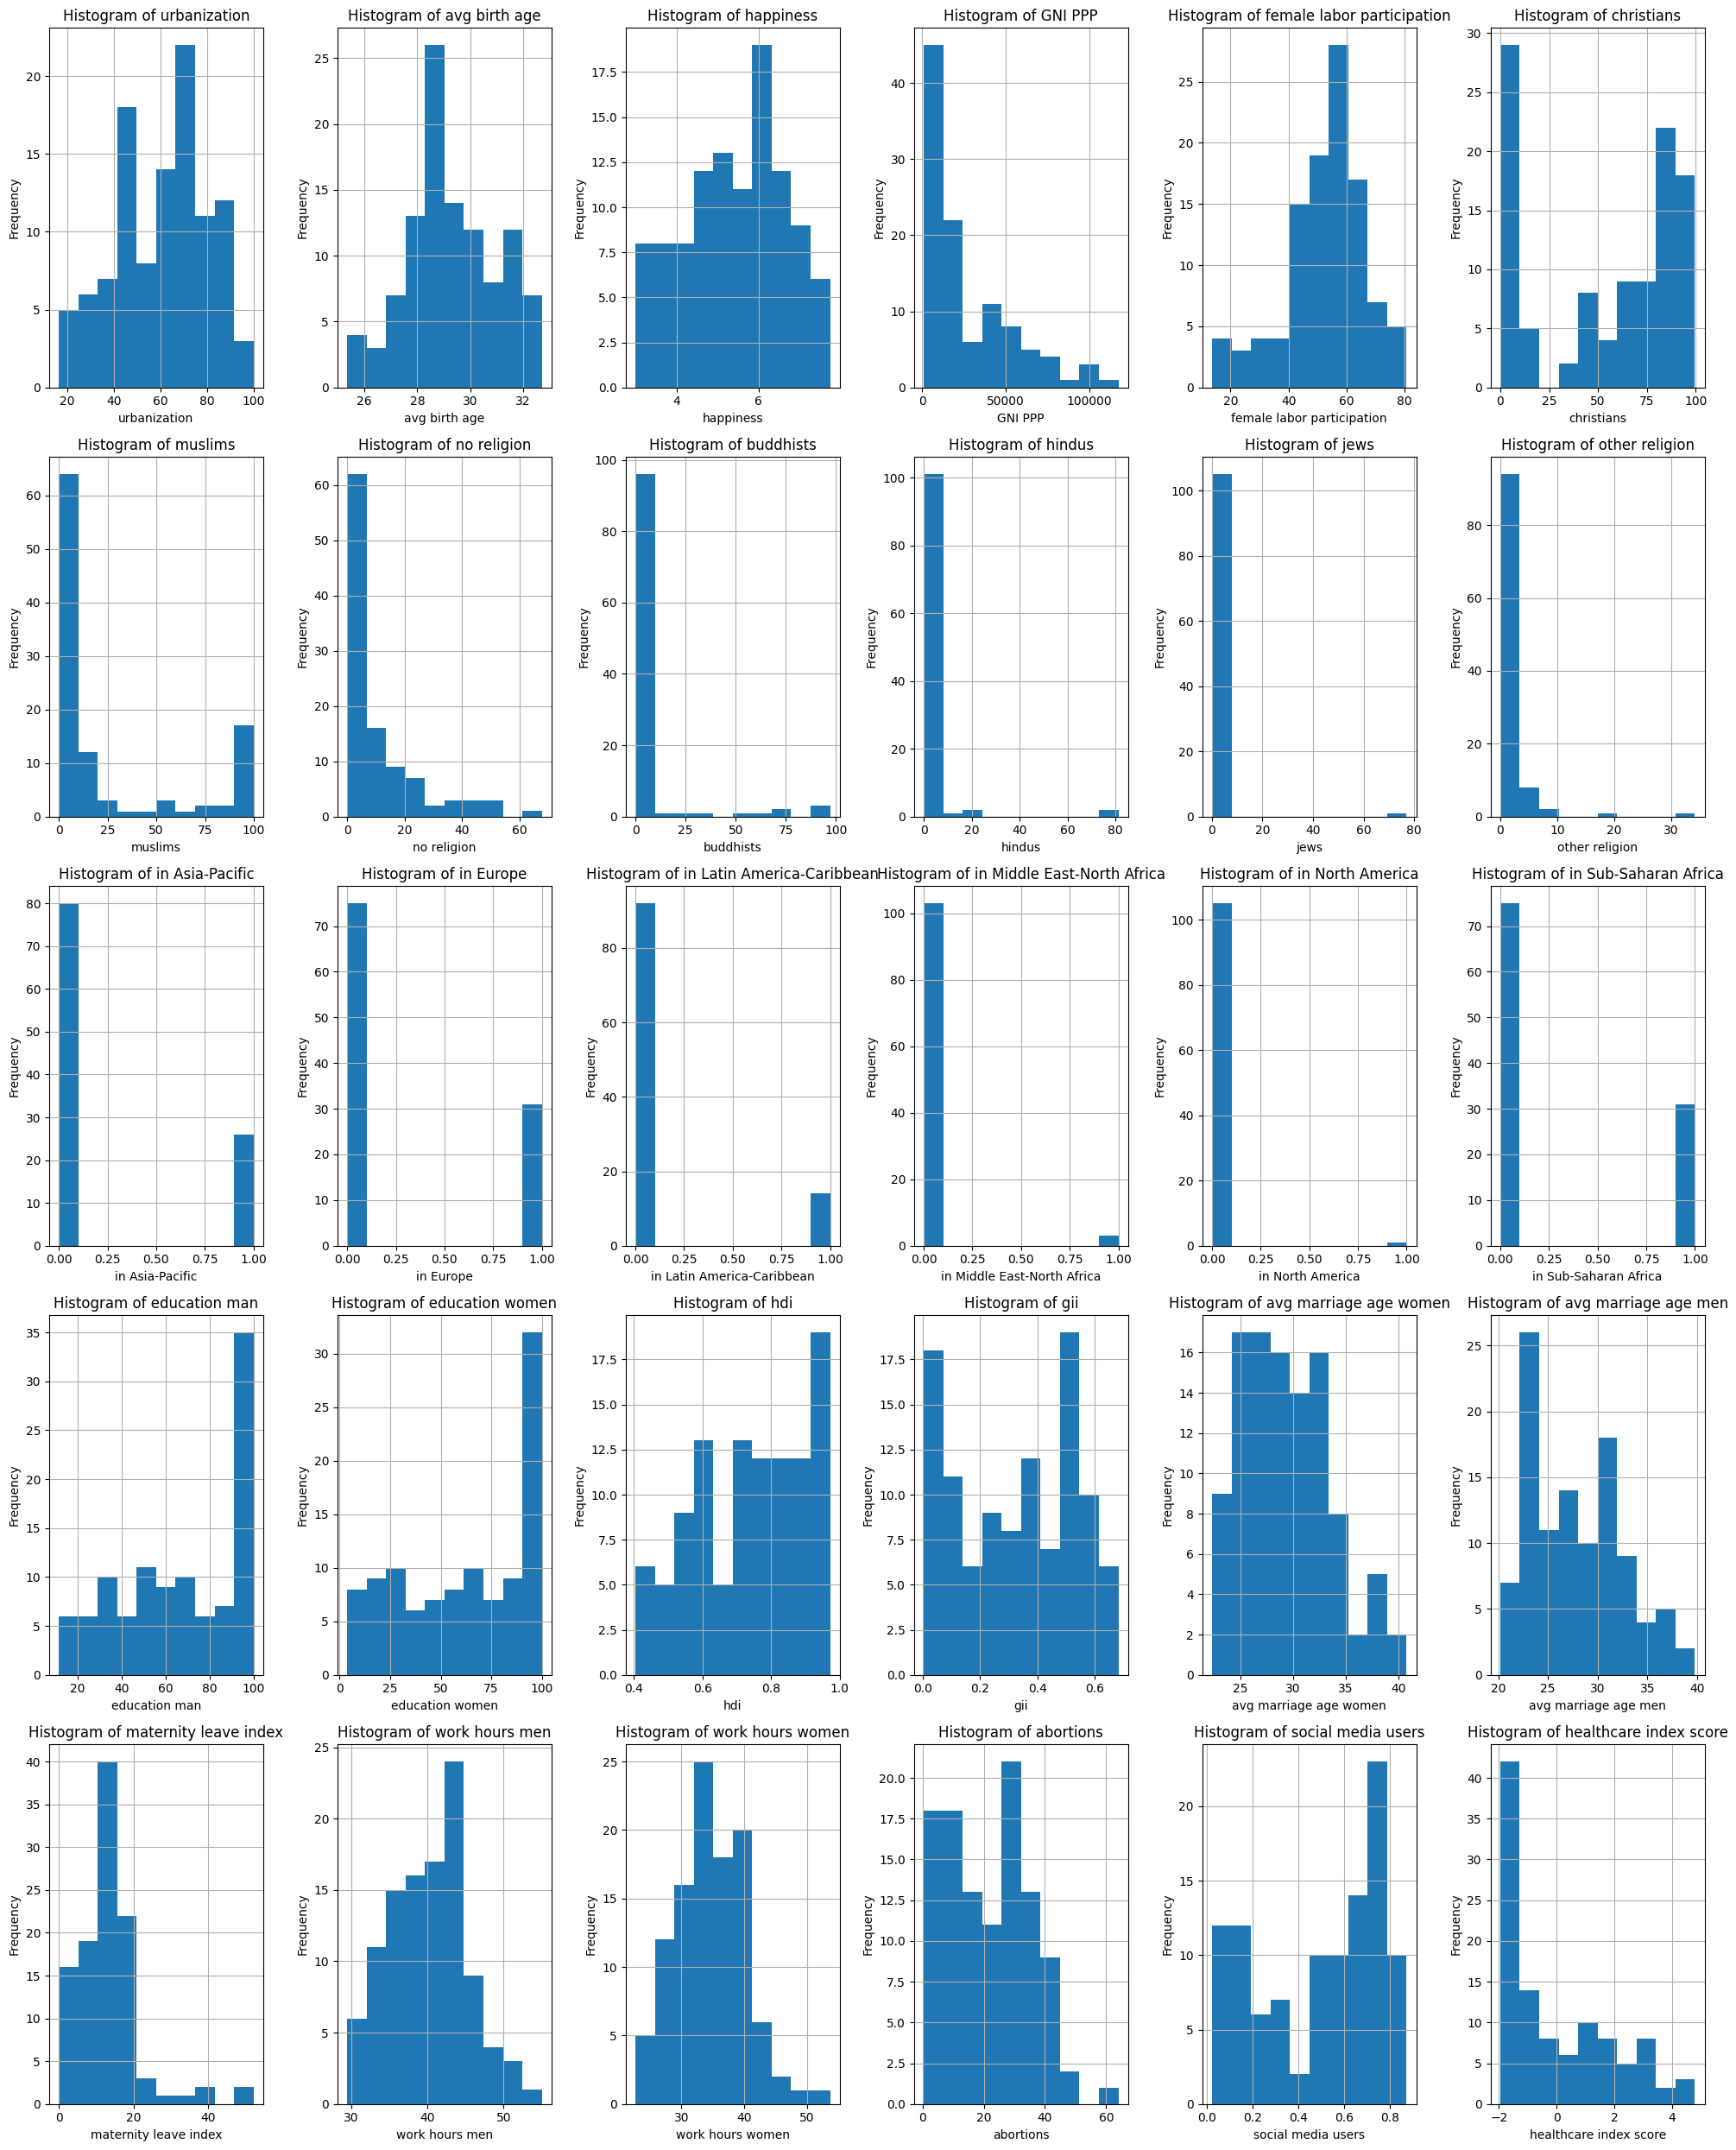

scaled features


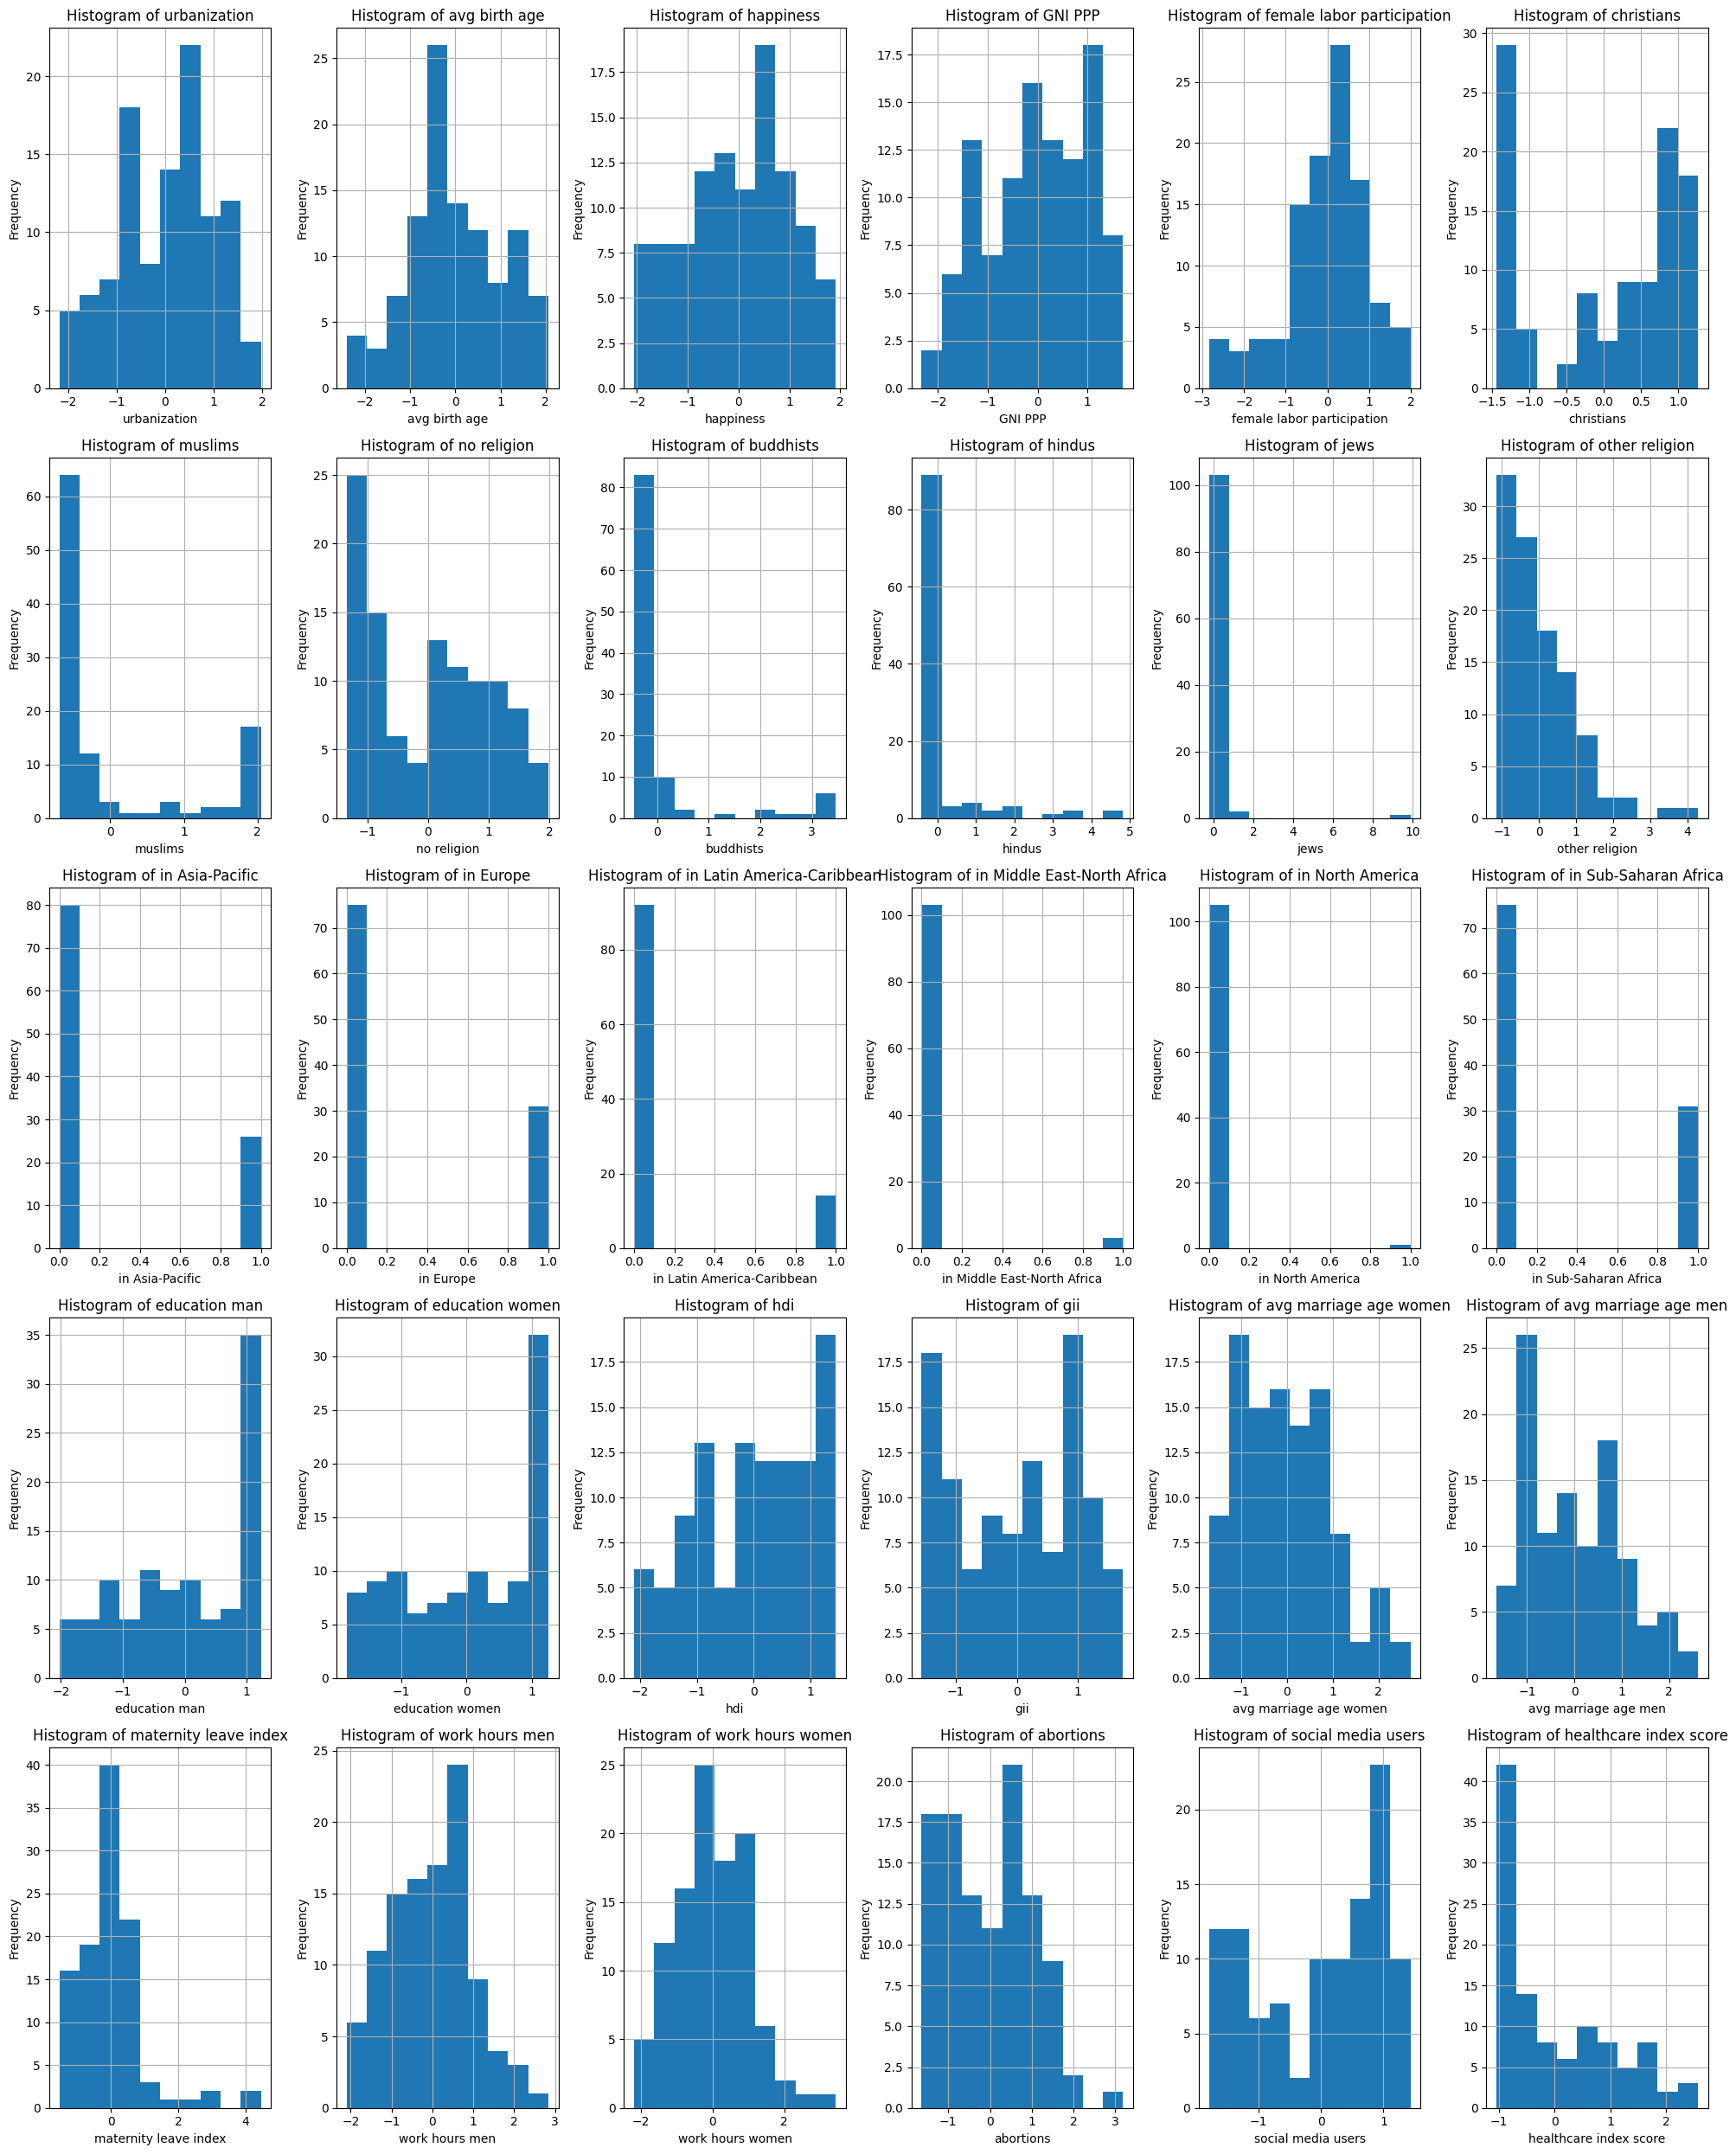

In [34]:
X_train, X_test, y_train, y_test = process_2023_data(init_process())
print('unscaled features')
plot_features(X_train)
lasso_train, lasso_test = lasso_scaling_2023(X_train, X_test)
print('scaled features')
plot_features(lasso_train)

In [37]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet

def gridsearch_loocv_lasso(X, y):
    lasso = Lasso()
    loo = LeaveOneOut()
    param_grid = {'alpha': [val * (10**i) for i in range(-12, 4) for val in [1, 2, 5]]}
    grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid,
                               cv=loo, scoring='neg_mean_squared_error',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search

def gridsearch_elastic_net_loocv(X, y):
    elastic_net = ElasticNet()
    loo = LeaveOneOut()
    param_grid = {'alpha': [val * (10**i) for i in range(-6, 2) for val in [1, 2, 5]],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0] # l1_ratio = 1.0 is Lasso
    }

    grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid,
                               cv=loo, scoring='neg_mean_squared_error',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search

In [36]:
# Assuming lasso_train and y_train are already defined from previous steps
grid_search_result = gridsearch_loocv_lasso(lasso_train, y_train)
print("Best parameters found: ", grid_search_result.best_params_)
print("Best cross-validation score (negative MSE): ", grid_search_result.best_score_)

# Get the best model from the grid search
best_lasso_model = grid_search_result.best_estimator_

# Print the coefficients
print("\nCoefficients of the best Lasso model:")
for feature, coef in zip(lasso_train.columns, best_lasso_model.coef_):
    print(f"{feature}: {coef:.4f}")

Best parameters found:  {'alpha': 0.02}
Best cross-validation score (negative MSE):  -0.3440423894062789

Coefficients of the best Lasso model:
urbanization: 0.0000
avg birth age: 0.1540
happiness: 0.0000
GNI PPP: -0.0000
female labor participation: 0.1518
christians: -0.0000
muslims: 0.1173
no religion: 0.0336
buddhists: -0.0331
hindus: -0.0573
jews: 0.1133
other religion: 0.0037
in Asia-Pacific: -0.0000
in Europe: -0.0000
in Latin America-Caribbean: -0.0000
in Middle East-North Africa: 0.0000
in North America: -0.0000
in Sub-Saharan Africa: 0.3983
education man: 0.0000
education women: 0.0000
hdi: -0.5652
gii: 0.1702
avg marriage age women: -0.0000
avg marriage age men: -0.1116
maternity leave index: 0.0037
work hours men: -0.0000
work hours women: -0.1030
abortions: 0.0000
social media users: -0.3845
healthcare index score: 0.0247


In [38]:
elastic_net_grid_search_result = gridsearch_elastic_net_loocv(lasso_train, y_train)

print("Best parameters found for Elastic Net (LOOCV): ", elastic_net_grid_search_result.best_params_)
print("Best cross-validation score (negative MSE) for Elastic Net (LOOCV): ", elastic_net_grid_search_result.best_score_)

# Get the best Elastic Net model
best_elastic_net_model = elastic_net_grid_search_result.best_estimator_

# Print the coefficients of the best Elastic Net model
print("\nCoefficients of the best Elastic Net model (LOOCV):")
for feature, coef in zip(lasso_train.columns, best_elastic_net_model.coef_):
    print(f"{feature}: {coef:.4f}")

Best parameters found for Elastic Net (LOOCV):  {'alpha': 0.1, 'l1_ratio': 0.1}
Best cross-validation score (negative MSE) for Elastic Net (LOOCV):  -0.32285680829956775

Coefficients of the best Elastic Net model (LOOCV):
urbanization: -0.0000
avg birth age: 0.1758
happiness: 0.0000
GNI PPP: -0.1844
female labor participation: 0.1469
christians: -0.0239
muslims: 0.1217
no religion: 0.0435
buddhists: -0.0703
hindus: -0.0652
jews: 0.1035
other religion: 0.0267
in Asia-Pacific: -0.0243
in Europe: -0.0000
in Latin America-Caribbean: -0.0768
in Middle East-North Africa: 0.0000
in North America: -0.0000
in Sub-Saharan Africa: 0.2639
education man: -0.0000
education women: -0.0093
hdi: -0.3372
gii: 0.2373
avg marriage age women: -0.0369
avg marriage age men: -0.1104
maternity leave index: 0.0000
work hours men: -0.0267
work hours women: -0.0800
abortions: 0.0230
social media users: -0.3521
healthcare index score: 0.0254
